In [148]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from random import *

In [150]:
# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

feature_names = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
class_names = iris.target_names

print("features:", feature_names)
print("classes:", class_names)

# Train a decision tree classifer
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
classes: ['setosa' 'versicolor' 'virginica']


DecisionTreeClassifier()

In [151]:
# Print some diagnostic information
n_nodes = clf.tree_.node_count              # the total number of nodes in the tree
children_left = clf.tree_.children_left     # the left child of every node, children_left[i] = node_id of i's left child
children_right = clf.tree_.children_right   # the same as above for the right child. A value of -1 in either array indicates a null child
feature = clf.tree_.feature                 # the column number of the feature used to split at each node, if i is a leaf node feature[i] is arbitrary 
threshold = clf.tree_.threshold             # the treshold used to split at each node, values <= threshold go to the left child otherwise the right child
                                            # the threshold value is arbitary for leaf nodes

print("n_nodes", n_nodes)
print("children_left", children_left)
print("children_right", children_right)
print("feature", feature)
print("threshold", threshold)

n_nodes 13
children_left [ 1 -1  3  4 -1  6 -1 -1  9 10 -1 -1 -1]
children_right [ 2 -1  8  5 -1  7 -1 -1 12 11 -1 -1 -1]
feature [ 2 -2  2  3 -2  1 -2 -2  2  1 -2 -2 -2]
threshold [ 2.35000002 -2.          4.95000005  1.65000004 -2.          3.10000002
 -2.         -2.          5.04999995  2.75       -2.         -2.
 -2.        ]


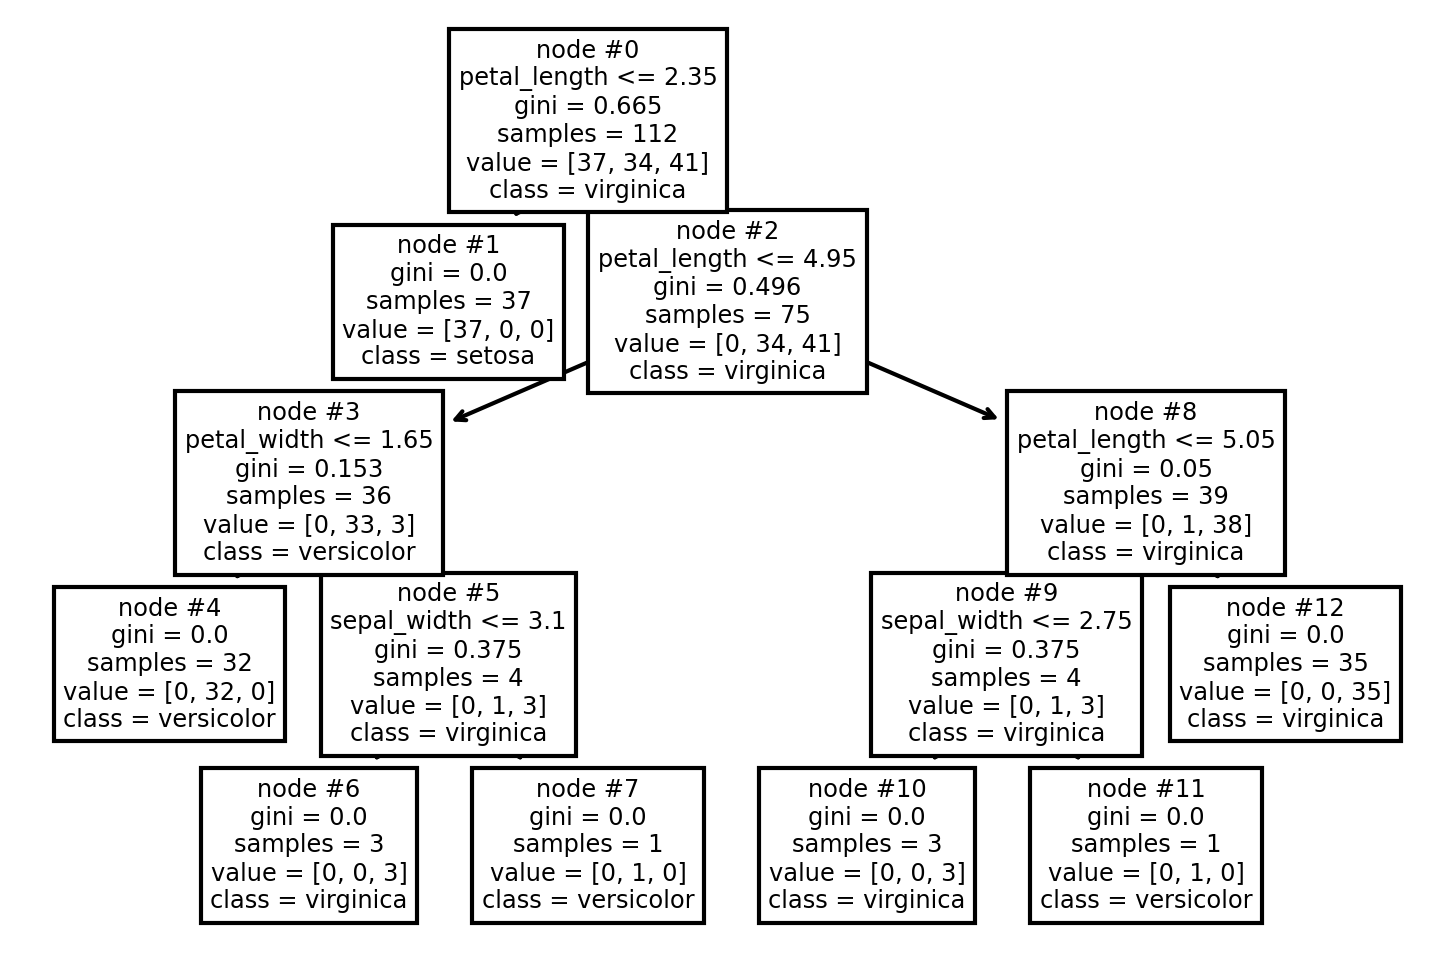

In [153]:
# Plot the tree, "value = [a, b, c, ..., m]" represents the number of samples from each class at the given node,
# e.g. value[0] is the number of samples of class 0 at the given node
fig = plt.figure()
fig.set_dpi(300)
fig.savefig("tree.png")
tree.plot_tree(decision_tree=clf, class_names=class_names, feature_names=feature_names, node_ids=True)
plt.show()

In [154]:
def in_order_path(t, all_paths=[], node_id=0, path=[], path_string="", verbose=False):
    '''
    An algorithm for pre-order binary tree traversal. This walks throuhg the entire tree generating a list of paths from the root node to a leaf
    and recording the final classification of the leaf node for that path. Paths are stored as `p = [f, g, h, i, j]` where each letter reprsents the
    node_id taken in that path, with `f` being the root node and `j` being the leaf node

    Parameters
    ----------
    t           : the decision tree classifier to travers
    all_paths   : the return values, a list of tuples (`class_id` = integer class ID, `path=[f, g, h, i, j]`)
    node_id     : the `node_id` to start traversal at, defaults to root node of tree (`node_id=0`)
    path        : the starting path up to by not including the node referenced by `node_id`, defaults to empty
    path_string : a running text explanation of the features and values used to split along the path
    verbose     : when true prints `path_string` during execution, `default=False`

    Returns
    -------
    None : see the output parameter `all_paths`
    '''
    # process current node
    if feature[node_id] >= 0: # if its a split node, get the attribute and value
        fname = feature_names[t.tree_.feature[node_id]]
        fvalue = t.tree_.threshold[node_id]
        path_component = "{fname} <= {fvalue:0.2f}, ".format(fname=fname, fvalue=fvalue)
    else: # otherwise its a leaf node, determine the class
        cid = np.argmax(t.tree_.value[node_id])
        cname = class_names[cid]
        path_component = "leaf: " + cname
    path_string = path_string + path_component
    path = path.copy()
    path.append(node_id)

    # If the node is a leaf
    if(t.tree_.children_left[node_id] == -1 and t.tree_.children_right[node_id] == -1):
        if(verbose):
            print(path)
            print(path_string)
        all_paths.append((cid, path))
        return

    # process left child
    in_order_path(t, all_paths, t.tree_.children_left[node_id], path, path_string, verbose) 

    # process right node
    in_order_path(t, all_paths, t.tree_.children_right[node_id], path, path_string, verbose)

In [155]:
def get_paths(t, verbose=False):
    '''
    A wrapper function to get all paths from tree t starting at the root node. See `in_order_path`
    '''
    all_paths = []
    in_order_path(t=t, all_paths=all_paths, verbose=verbose)
    return all_paths

In [157]:
# Use the above functions to enumerate all the paths of the decision tree classifier
mypaths = get_paths(t=clf, verbose=True)

[0, 1]
petal_length <= 2.35, leaf: setosa
[0, 2, 3, 4]
petal_length <= 2.35, petal_length <= 4.95, petal_width <= 1.65, leaf: versicolor
[0, 2, 3, 5, 6]
petal_length <= 2.35, petal_length <= 4.95, petal_width <= 1.65, sepal_width <= 3.10, leaf: virginica
[0, 2, 3, 5, 7]
petal_length <= 2.35, petal_length <= 4.95, petal_width <= 1.65, sepal_width <= 3.10, leaf: versicolor
[0, 2, 8, 9, 10]
petal_length <= 2.35, petal_length <= 4.95, petal_length <= 5.05, sepal_width <= 2.75, leaf: virginica
[0, 2, 8, 9, 11]
petal_length <= 2.35, petal_length <= 4.95, petal_length <= 5.05, sepal_width <= 2.75, leaf: versicolor
[0, 2, 8, 12]
petal_length <= 2.35, petal_length <= 4.95, petal_length <= 5.05, leaf: virginica


In [158]:
def construct_examples(t, x, y, difference=0.01, verbose=False):
    '''
    A function to contruct a set of contrastive examples for the tree `t` such that each example has a predicted class different than that of `x`.
    This is done by making minimal modifications to x such that it follows a path from the root of `t` to a leaf node with a predicted class other
    than that of `y`
    
    Parameters
    ----------
    t          : the decision tree to be used in contrastive example generation
    x          : the sample to generate contrastive examples for
    y          : the class of the given sample `x`
    difference : the percent change to apply to each feature to "nudge" the c
    verbose    : when true prints the path for each example generated and the expected class of that paths leaf node

    Returns
    -------
    examples   : a list of minimally modified versions of `x`, one for each path from the root node to a leaf with a class other than `y`
    '''
    # get all the paths from root to leaf
    all_paths = get_paths(t)
    
    # initialize empty output array of contrastive examples
    examples = []
    
    # for every possible path from root to leaf
    for path_class, path in all_paths:
        # if the result of that path is a label the same as x, skip it
        if path_class == y:
            continue
        
        # print the path for the current example being generated
        if verbose:
            print(path_class, path)
        
        # initialize a constastive example as x
        xprime = x.copy()
        
        # following the given path up to (but not including) the leaf node
        for i in range(len(path)-1):
            node_id = path[i]           # the current node in the path
            next_node_id = path[i+1]    # the next node in the path

            fid = t.tree_.feature[node_id]          # get the feature the current node splits on
            fthreshold = t.tree_.threshold[node_id] # get the value the current node splits on
                
            # if the path goes left and x went right, force xprime left
            if (next_node_id == t.tree_.children_left[node_id] and xprime[fid] > fthreshold):
                xprime[fid] = fthreshold - np.abs(difference * fthreshold)

            # if the path goes right and x went left, force xprime right
            if (next_node_id == t.tree_.children_right[node_id] and xprime[fid] <= fthreshold):
                xprime[fid] = fthreshold + np.abs(difference * fthreshold)

        # save the example
        examples.append(xprime)
    return examples


In [159]:
# Prepare to test the contrastive example generation
xid = randint(0, iris.data.shape[0]-1)  # get a random sample from the data
x = iris.data[xid:xid+1]
y_true = iris.target[xid:xid+1][0]      # find its true label
y_pred = clf.predict(x)[0]              # and its predicted label

print("x:", x)
print("true class: {cid}, {cname}".format(cid=y_true, cname=class_names[y_true]))
print("pred class: {cid}, {cname}".format(cid=y_pred, cname=class_names[y_pred]))

# print the path that sample takes from the root node to the leaf node using sklearn function
# "(a, b)    c" represents the node b and the number of samples a which go through that node
print(clf.decision_path(x))

x: [[6.1 3.  4.9 1.8]]
true class: 2, virginica
pred class: 2, virginica
  (0, 0)	1
  (0, 2)	1
  (0, 3)	1
  (0, 5)	1
  (0, 6)	1


In [160]:
# Create contrastive examples and chey they have a different class than x
print("x:", x)
print("x has class", y_pred)

# Create the examples, prints the expected class_id and the path for each example
examples = construct_examples(t=clf, x=x[0], y=y_pred, verbose=True)

# Display the created examples
print()
print("contrastive examples:")
print(feature_names)
for ex in examples:
    print(ex)

x: [[6.1 3.  4.9 1.8]]
x has class 2
0 [0, 1]
1 [0, 2, 3, 4]
1 [0, 2, 3, 5, 7]
1 [0, 2, 8, 9, 11]

contrastive examples:
['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
[6.1        3.         2.32650002 1.8       ]
[6.1        3.         4.9        1.63350004]
[6.1        3.13100002 4.9        1.8       ]
[6.1        3.         4.99950005 1.8       ]


In [161]:
# Checking the predicted class of the examples
# these should correspond to the expected class_id from above
candidates = np.array(examples)
pred_classes = clf.predict(candidates)
print(pred_classes)

[0 1 1 1]


In [2]:
import numpy as np
ntrees = 20
print(np.floor(ntrees / 2) + 1)

11.0
